# 590 Final Project - The Optimization of Flight Overbooking 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics as st
import re
import time


# First we have to get the aircraft type and decide the seats, the user can input the aircraft type
# create a dictionary in which the key is the aircraft type and the value is capability

class flight:
    
    """
        This is a kind of object-oriented class. It stores the necessary information of flight,
        including airplane type, capacity, each class cost and special day discrimination.

    """
    
    aircraft_type = {'Boeing737': 118, 'Boeing757': 170, 'Boeing767': 235,
                     'Boeing777': 321, 'Boeing787': 270, 'A350': 348}

    spec_day = {'01-15', '05-28', '07-04', '09-03', '10-08', '11-11', '11-22', '12-25'}

    bu_cost_dict = {'Boeing737': 150, 'Boeing757': 150, 'Boeing767': 150,
                    'Boeing777': 150, 'Boeing787': 150, 'A350': 150}

    ec_cost_dict = {'Boeing737': 100, 'Boeing757': 100, 'Boeing767': 100,
                    'Boeing777': 100, 'Boeing787': 100, 'A350': 100}

    def __init__(self, type, capacity, is_spec_day, bu_cost, ec_cost):
        self.type = type
        self.capacity = capacity
        self.is_spec_day = is_spec_day
        self.bu_cost = bu_cost
        self.ec_cost = ec_cost

    @classmethod
    def get_attributes(cls):
        
        '''
        We can get types of airplane,  different types of airplane have different seats,
        as well as different cost. Also, we will see if the day is special day, which will
        inflence the compensation.

        :return: return to the flight class itself
        
        '''

        localtime = time.strftime('%m-%d', time.localtime(time.time()))
        is_spec_day = localtime in flight.spec_day

        type = input('Please type your Aircraft type: ')
        pattern = re.compile(r'(Boeing7[35678]7)|(A350)', re.I)
        m = pattern.match(type)

        if m:
            if type[0] == 'B' or type[0] == 'b':
                type = 'Boeing' + type[-3:]
            else:
                type = 'A' + type[-3:]

            capacity = flight.aircraft_type[type]
            bu_cost = flight.bu_cost_dict[type]
            ec_cost = flight.ec_cost_dict[type]

            return cls(type, capacity, is_spec_day, bu_cost, ec_cost)
        else:
            print('This is invalid aircraft type. Please try again.')
            return flight.get_attributes()


# We assumen that demand and overbooking are both binormal distribution
def get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, capacity):
    
    '''
    By creating the random number which according with binomial distribution, 
    we can get demand_num, sales_num and showup_num

    :param demand_hyp: the maximum number of overbooking, int data type
    :param demand_prob: the probability of each person's ticket reservation, float data type
    :param showup_prob: the probability of each person's attendance,float data type
    :param overbook_num: the number of overbooking,int data type
    :param capacity: the maximum number of airplane seats
    :return: sales number and show up number
    
    >>> random.seed(1)
    >>> get_variables(83, 0.9, 0.85, 1, 69)[0]
    70
    
    '''

    demand_num = np.random.binomial(demand_hyp, demand_prob)
    # The demand_num accord with binomial distribution

    sales_num = demand_num if demand_num <= capacity else capacity + overbook_num

    showup_num = np.random.binomial(sales_num, showup_prob)
    # The demand_num accord with binomial distribution

    return sales_num, showup_num


def get_rev(sales_num, capacity, showup_num, profit, is_spec_day):
    
    '''
    By calling this function, we can get the revenue of this flight.

    :param sales_num: the sale number of tickets, int data type
    :param capacity: the number of airplane seats, int data type
    :param showup_num: the number of passengers' attendance
    :param profit: the amount of each seat's profit, float data type
    :param is_spec_day: the specific date (string data type) or None
    :return: the amount of revenue per flight, float data type
    
    >>> random.seed(1)
    >>> get_rev(70, 69, 65, 60, None)
    4200
    
    '''
    
    loss = []
    if showup_num <= capacity:
        revenue = profit * sales_num  # assume no refund for the no_show
    else:
        for i in range(showup_num - capacity):

            # compensation according to the us federal. And we consider holidays there. 
            # When confronting the special days, there will be no empty seats in the next flight, 
            # so we assume that the probability of compensating 400$ is 0.75 
            # and the the probability of compensating 800$ is 0.25.
            if is_spec_day:
                compensation = np.random.choice(np.array([400, 800]), p=[0.75, 0.25])
                print(
                    'Today is a special day, we are so sorry that there is no empty' + 
                    'seat in the next flight. You will get' + compensation +
                    'dollars for compensation')
            else:
                # If the day is the normal day
                compensation = np.random.choice(np.array([0, 400, 800]), p=[0.6, 0.3, 0.1])
            single_loss = compensation
            loss.append(single_loss)
        revenue = profit * sales_num - sum(loss)
    return revenue


def Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, demand_hyp_ec, is_spec_day, bu_cost, ec_cost):
    
    '''
    Monte Carlo simulation
    we simulate the situation when overbook number is from 0 to 30, and for each scenario, 
    we simulate for 1000 times.

    :param capacity_all: the total number of all airplane seats, int data type
    :param showup_prob: the probability of each person's ticket reservation, float data type
    :param demand_prob: the probability of each person's attendance, float data type
    :param demand_hyp_bu: the maximum number of business class overbooking, int data type
    :param demand_hyp_ec: the maximum number of economy class overbooking, int data type
    :param is_spec_day: the specific date (string data type) or None
    :param bu_cost: the cost of each business seat, int data type
    :param ec_cost: the cost of each economy seat, int data type
    :return: the dictionary data type with the information of overbooking number, 
                mean revenue of business class per overbooking number, 
                mean revenue of business class per overbooking number, mean revenue
                of whole airplane per overbooking number
    
    >>> len(Monte_Carlo(348, 0.85, 0.9, 83, 334, None, 150, 100)['revenue_means'])
    31
                
    '''
    
    simu_result = {'revenue_means': [], 'plot_1': []}
    fare_class = ["business", "economics"]

    for i in range(0, 31):  # overbooking range is 0 and 30
        total_revenue_list = []
        revenue_ec, revenue_bu = [], []
        for n in range(1000):
            overbook_ec = random.randint(0, i + 1)
            overbook_bu = i - overbook_ec
            revenue_list = []
            for cs in fare_class:

                if cs == "business":
                    cost = bu_cost  # of each seat
                    profit = cost * 0.4
                    capacity = int(capacity_all * 0.2)
                    overbook_num = overbook_bu
                    demand_hyp = demand_hyp_bu
                else:
                    cost = ec_cost  # of each seat
                    profit = cost * 0.2
                    capacity = capacity_all - capacity
                    overbook_num = overbook_ec
                    demand_hyp = demand_hyp_ec

                variables = get_variables(demand_hyp, demand_prob, showup_prob, overbook_num, 
                                          capacity)
                sales_num = variables[0]
                showup_num = variables[1]

                revenue = get_rev(sales_num, capacity, showup_num, profit, is_spec_day)
                revenue_list.append(revenue)

            revenue_ec.append(revenue_list[0])
            revenue_bu.append(revenue_list[1])
            total_revenue = sum(revenue_list)
            total_revenue_list.append(total_revenue)

        revenue_mean = st.mean(total_revenue_list)
        revenue_mean_ec = st.mean(revenue_ec)
        revenue_mean_bu = st.mean(revenue_bu)
        simu_result['revenue_means'].append((i, revenue_mean_bu, revenue_mean_ec, revenue_mean))
        simu_result['plot_1'].append(revenue_mean)

    return simu_result


class result:
    
    """
    This is a kind of object-oriented class. It stores the output by means of calling 
    the functions to get the different type of result.
    
    """
    
    def __init__(self, plot=None, frame=None, max_rev=None):
        self.plot = plot
        self.frame = frame
        self.max_rev = max_rev

    def get_plot(self, simu_result):
        
        """
        The purpose of this function is to get the plot type of result and store the result
        in the attribute of class.
        
        :param simu_result: the simulation revenue result stored in the dictionary
        :return: No return
        
        """
        
        self.plot = plt.plot(simu_result['plot_1'])

    def get_frame(self, simu_result):
        
        """
        The purpose of this function is to get the plot type of result and store the result 
        in the attribute of class.
        
        :param simu_result: the simulation revenue result stored in the dictionary
        :return: No return
        
        """
        
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.width', 1000)
        self.frame = pd.DataFrame(data=simu_result['revenue_means'], columns=[
            'Overbooking Number', 'Business Revenue', 'Economic Revenue', 
            'Estimated Total Revenue'])

    def get_max_rev(self, capacity_all):
        
        """
        The purpose of this function is to get the plot type of result and store the result
        in the attribute of class.
        
        :param capacity_all: the information about airplane seats stored in the flight class
        :return: No return
        
        """
        
        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Number'] / capacity_all * 100
        })
        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Percentage'].map('{:.2f}%'.format)
        })

        self.max_rev = self.frame.loc[self.frame['Estimated Total Revenue'].idxmax()]
        
    def get_max_rev(self, capacity_all):
        
        """
        The purpose of this function is to get the maximum of mean revenue and find 
        the optimization result of overbooking number.
        
        :param capacity_all: the total number of whole airplane seats, int data type
        :return: No return 
        
        """

        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Number'] / capacity_all * 100
        })
        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Percentage'].map('{:.2f}%'.format)
        })

        self.max_rev = self.frame.loc[self.frame['Estimated Total Revenue'].idxmax()]


if __name__ == '__main__':

    flight = flight.get_attributes()
    capacity_all = flight.capacity
    
    print('This type of airplane has ' + str(capacity_all) + ' seats. \n')

    print('According to the research, at most time, the probability of person to show up should' +
          'be 0.85 and the demand probability should be 0.9.\n' +
        'But this is just our suggestion,you can type your own answer\n')

    showup_prob = float(input('The probability of person to show up is:'))
    demand_prob = float(input('The demand probability is:'))

    print('Just wait for a minute, we are calculating for you!')

    demand_hyp_bu = int(capacity_all * 1.2 * 0.2)  # assume largest demand is about 120% of 
                                                                     # the capacity
    demand_hyp_ec = int(capacity_all * 1.2) - demand_hyp_bu

    simu_result = Monte_Carlo(capacity_all, showup_prob, demand_prob, demand_hyp_bu, 
                              demand_hyp_ec, flight.is_spec_day, flight.bu_cost, flight.ec_cost)

Please type your Aircraft type: a350
This type of airplane has 348 seats. 

According to the research, at most time, the probability of person to show up shouldbe 0.85 and the demand probability should be 0.9.
But this is just our suggestion,you can type your own answer

The probability of person to show up is:0.85
The demand probability is:0.9
Just wait for a minute, we are calculating for you!


In [2]:
data_frame = result()
data_frame.get_frame(simu_result)
data_frame.frame

,Overbooking Number,Business Revenue,Economic Revenue,Estimated Total Revenue
0,0,5590.04,4109.58,9699.62
1,1,5599.38,4140.90,9740.28
2,2,5609.88,4168.26,9778.14
3,3,5619.40,4196.10,9815.50
4,4,5630.10,4223.48,9853.58
5,5,5637.46,4263.90,9901.36
6,6,5650.84,4277.42,9928.26
7,7,5659.46,4311.04,9970.50
8,8,5671.96,4329.84,10001.80
9,9,5677.86,4365.46,10043.32


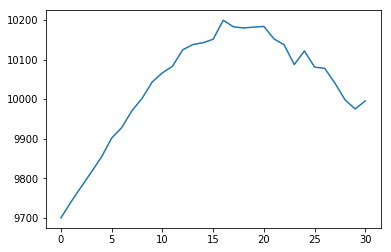

In [3]:
data_frame.get_plot(simu_result)
data_frame.plot

In [4]:
data_frame.get_max_rev(capacity_all)
data_frame.max_rev

Overbooking Number              16
Business Revenue            5749.5
Economic Revenue            4449.8
Estimated Total Revenue    10199.3
Overbooking Percentage       4.60%
Name: 16, dtype: object